<a href="https://colab.research.google.com/github/JeromeNickson/Quantum-Portfolio-Optimization/blob/main/notebooks/quantum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install yfinance pennylane matplotlib

# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 55.1 MB/s eta 0:00:00


In [2]:
# Download same stock data as markowitz.ipynb for consistency
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META"]
data = yf.download(tickers, start="2020-01-01", end="2022-01-01")["Close"]

# Calculate daily returns
returns = data.pct_change().dropna()

# Compute annualized mean and covariance (same as Markowitz)
mu = returns.mean().values * 252        # annual expected returns
Sigma = returns.cov().values * 252      # annual covariance
n = len(tickers)

print("Assets:", tickers)
print("Annualized Returns:", mu)
print("Covariance Matrix:\n", Sigma)


/tmp/ipython-input-3494063538.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2022-01-01")["Close"]
[*********************100%***********************]  5 of 5 completed

Assets: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
Annualized Returns: [0.50818937 0.33335037 0.4269322  0.3107182  0.43847588]
Covariance Matrix:
 [[0.14039476 0.08070658 0.08413939 0.10086635 0.1039322 ]
 [0.08070658 0.10328675 0.06700121 0.07851132 0.07696647]
 [0.08413939 0.06700121 0.10345879 0.09125095 0.09086261]
 [0.10086635 0.07851132 0.09125095 0.14896206 0.09283901]
 [0.1039322  0.07696647 0.09086261 0.09283901 0.11844947]]


In [14]:
!git clone https://github.com/JeromeNickson/Quantum-Portfolio-Optimization.git


Cloning into 'Quantum-Portfolio-Optimization'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 45 (delta 11), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 88.72 KiB | 272.00 KiB/s, done.
Resolving deltas: 100% (11/11), done.


In [15]:
%cd Quantum-Portfolio-Optimization/notebooks


/content/Quantum-Portfolio-Optimization/notebooks


In [16]:
!pwd
!ls


/content/Quantum-Portfolio-Optimization/notebooks
markowitz.ipynb  quantum.ipynb


In [19]:
!pwd
!ls ../utils


/content/Quantum-Portfolio-Optimization/notebooks
markowitz_utils.py  __pycache__


In [17]:
import sys
sys.path.append("../utils")


In [22]:
from markowitz_utils import run_markowitz

# Call Markowitz function
tangency_weights, tangency_return, tangency_risk, risks, rets = run_markowitz(mu, Sigma, rf)

# Compute max Sharpe ratio separately
sharpe_ratios = [(r - rf)/s if s>0 else -1 for r,s in zip(rets, risks)]
max_idx = np.argmax(sharpe_ratios)
sharpe_ratio = sharpe_ratios[max_idx]

# Display
print("Tangency Portfolio Weights (Max Sharpe):")
for i, t in enumerate(tickers):
    print(f"{t}: {tangency_weights[i]:.4f}")

print("\nExpected Annual Return:", round(tangency_return,4))
print("Expected Annual Risk (Volatility):", round(tangency_risk,4))
print("Sharpe Ratio:", round(sharpe_ratio,4))



Tangency Portfolio Weights (Max Sharpe):
0.5040408338917185: 0.5040
2.666937614015057e-22: 0.0000
0.4959591661082815: 0.4960
3.6493924117477634e-22: 0.0000
5.477521293305447e-23: 0.0000

Expected Annual Return: 0.4679
Expected Annual Risk (Volatility): 0.3212
Sharpe Ratio: 1.3943


In [3]:
# -------------------------
# Cell 3: Build QUBO
# -------------------------
# Hyperparameters (tuneable)
k = 3           # number of assets to select (cardinality)
lam = 0.6       # risk vs return trade-off (0..1). Larger -> more risk-averse
A = 10.0        # penalty weight for cardinality constraint (increase if cardinality not enforced)

# Build QUBO matrix Q such that cost = x^T Q x (x in {0,1}^n)
Q = np.zeros((n, n))

# 1) Risk term (quadratic): lam * x^T Sigma x
Q += lam * Sigma

# 2) Return term (linear): we want to maximize mu^T x => minimize - (1-lam) * mu^T x
for i in range(n):
    Q[i, i] += - (1.0 - lam) * mu[i]

# 3) Cardinality penalty: A * (sum_i x_i - k)^2
# Expand: A * ( sum_i x_i + 2 sum_{i<j} x_i x_j - 2k sum_i x_i + k^2 )
# So diagonal gets A*(1 - 2k), off-diagonals get 2A
for i in range(n):
    Q[i, i] += A * (1 - 2 * k)
for i in range(n):
    for j in range(i + 1, n):
        Q[i, j] += 2 * A
        Q[j, i] += 2 * A

# Q is the final QUBO matrix
print("QUBO matrix Q (shape {}):\n".format(Q.shape), np.round(Q, 4))


QUBO matrix Q (shape (5, 5)):
 [[-50.119   20.0484  20.0505  20.0605  20.0624]
 [ 20.0484 -50.0714  20.0402  20.0471  20.0462]
 [ 20.0505  20.0402 -50.1087  20.0548  20.0545]
 [ 20.0605  20.0471  20.0548 -50.0349  20.0557]
 [ 20.0624  20.0462  20.0545  20.0557 -50.1043]]


In [4]:
# -------------------------
# Cell 4: QUBO -> Ising and Hamiltonian
# -------------------------
def qubo_to_ising(Q):
    # Convert QUBO (x in {0,1}) to Ising (z in {-1,1}) form:
    # x = (1 - z)/2  =>  x_i x_j = (1 - z_i - z_j + z_i z_j)/4
    n = Q.shape[0]
    const = 0.0
    h = np.zeros(n)      # linear Z coefficients
    J = np.zeros((n, n)) # ZZ coefficients

    # Compute constant, linear, and quadratic terms
    for i in range(n):
        for j in range(n):
            qij = Q[i, j]
            const += qij * 0.25        # from (1/4) * qij
    const = const  # already summed

    # Linear (h) and quadratic (J)
    for i in range(n):
        # diagonal contributions: Q[ii] * x_i^2 => x_i = (1-z_i)/2 => contributes (Q_ii/4) - (Q_ii/2) z_i/2?
        # Simpler to compute from expansion of x^T Q x
        # We'll compute h and J by expanding formula:
        # x^T Q x = sum_{i,j} Q_ij * (1 - z_i - z_j + z_i z_j)/4
        # Collect z_i and z_i z_j coefficients directly:
        pass

    # Explicit expansion to avoid algebra mistakes:
    # Initialize accumulators
    const = 0.0
    h = np.zeros(n)
    J = np.zeros((n,n))

    for i in range(n):
        for j in range(n):
            qij = Q[i, j]
            const += qij * 0.25                     # (1/4) * Q_ij
            h[i] += -0.25 * qij                     # from -z_i * Q_ij /4
            # note: contribution to h[j] from this pair will be handled when loop reaches j,i
            # For the z_i z_j term:
    # Now handle z_i z_j (i<j) properly:
    for i in range(n):
        for j in range(i+1, n):
            qij = Q[i, j]
            J[i, j] += 0.25 * qij
            J[j, i] = J[i, j]
            # adjust h because earlier double counted -0.25 * qij for both h[i] and h[j]
            # The previous loop already added -0.25*qij to h[i] and -0.25*qji (same) to h[j]
            # So no further adjustment needed here.

    # Note: diagonal Q_ii terms have been handled in const and h above.
    # Return const, h, J
    return const, h, J

const, h, J = qubo_to_ising(Q)

# Build PennyLane Hamiltonian H_cost = const + sum_i h_i Z_i + sum_{i<j} J_ij Z_i Z_j
coeffs = []
ops = []
for i in range(n):
    if abs(h[i]) > 1e-12:
        coeffs.append(float(h[i]))
        ops.append(qml.PauliZ(i))
for i in range(n):
    for j in range(i+1, n):
        if abs(J[i, j]) > 1e-12:
            coeffs.append(float(J[i, j]))
            ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

H_cost = qml.Hamiltonian(coeffs, ops)
print("Hamiltonian built: {} terms".format(len(coeffs)))


Hamiltonian built: 15 terms


In [5]:
# -------------------------
# Cell 5: QAOA circuit + optimization (fixed float issue)
# -------------------------
p = 2   # QAOA depth
dev = qml.device("default.qubit", wires=n)

@qml.qnode(dev, interface="autograd")
def qaoa_expectation(gammas, betas):
    # initial |+>^n
    for i in range(n):
        qml.Hadamard(wires=i)
    # p layers
    for layer in range(p):
        # cost unitary (approximate)
        qml.ApproxTimeEvolution(H_cost, gammas[layer], 1)
        # mixer
        for i in range(n):
            qml.RX(2.0 * betas[layer], wires=i)
    return qml.expval(H_cost)

# Initialize parameters as pennylane numpy arrays (autograd-compatible)
rng = np.random.default_rng(123)
gammas = pnp.array(rng.uniform(0, 2*np.pi, size=(p,)), requires_grad=True)
betas  = pnp.array(rng.uniform(0, 2*np.pi, size=(p,)), requires_grad=True)

# Optimizer
opt = qml.AdamOptimizer(stepsize=0.1)
max_iters = 60

print("Starting QAOA optimization...")
for it in range(max_iters):
    gammas, betas = opt.step(lambda g,b: qaoa_expectation(g,b), gammas, betas)
    if (it+1) % 10 == 0 or it == 0:
        val = qaoa_expectation(gammas, betas)
        print(f" Iter {it+1:3d}: expectation = {val:.6f}")
print("QAOA optimization finished. Final expectation:", qaoa_expectation(gammas, betas))


Starting QAOA optimization...
 Iter   1: expectation = 23.404607
 Iter  10: expectation = -10.843099
 Iter  20: expectation = -11.856883
 Iter  30: expectation = -14.108994
 Iter  40: expectation = -14.120502
 Iter  50: expectation = -14.501799
 Iter  60: expectation = -14.571660
QAOA optimization finished. Final expectation: -14.57165982346009


In [8]:
# -------------------------
# Cell 6: Sample bitstrings from final QAOA state
# -------------------------

shots = 1000  # number of samples to draw

# Create a new device in sampling mode
dev_sample = qml.device("default.qubit", wires=n, shots=shots)

@qml.qnode(dev_sample)
def qaoa_sampling(gammas, betas):
    # initial |+>^n
    for i in range(n):
        qml.Hadamard(wires=i)
    # QAOA layers
    for layer in range(p):
        qml.ApproxTimeEvolution(H_cost, gammas[layer], 1)
        for i in range(n):
            qml.RX(2.0 * betas[layer], wires=i)
    return qml.sample(wires=range(n))

# Sample the circuit
samples = qaoa_sampling(gammas, betas)
samples = np.array(samples)

# Convert samples to bitstrings
bitstrings = ["".join(str(b) for b in sample) for sample in samples]
unique, counts = np.unique(bitstrings, return_counts=True)

print("Top QAOA solutions (most frequent bitstrings):")
for b, c in sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  {b}  ->  freq: {c} ({100*c/shots:.2f}%)")


Top QAOA solutions (most frequent bitstrings):
  00011  ->  freq: 94 (9.40%)
  10001  ->  freq: 76 (7.60%)
  01001  ->  freq: 72 (7.20%)
  11000  ->  freq: 70 (7.00%)
  00110  ->  freq: 69 (6.90%)


In [10]:
# -------------------------
# Cell 7: Convert best bitstring to portfolio weights
# -------------------------
rf = 0.02  # risk-free rate (2%)

# Take the most frequent bitstring as the "optimal" solution
best_bitstring = sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)[0][0]

# Determine selected assets
selected_assets = [tickers[i] for i, bit in enumerate(best_bitstring) if bit == "1"]

# Avoid division by zero if no assets are selected
if len(selected_assets) == 0:
    print("Warning: No assets selected by QAOA. Using equal weights fallback.")
    weights_qaoa = np.ones(n) / n
else:
    weights_qaoa = np.array([1/len(selected_assets) if bit == "1" else 0 for bit in best_bitstring])

# Compute portfolio metrics for QAOA solution
ret_qaoa = np.dot(mu, weights_qaoa)
risk_qaoa = np.sqrt(weights_qaoa.T @ Sigma @ weights_qaoa)
sharpe_qaoa = (ret_qaoa - rf) / risk_qaoa

# Display results
print("\nQAOA Selected Portfolio:")
for i, t in enumerate(tickers):
    print(f"  {t}: {weights_qaoa[i]:.2f}")

print(f"\nExpected Return (annual): {ret_qaoa:.4f}")
print(f"Expected Risk (volatility): {risk_qaoa:.4f}")
print(f"Sharpe Ratio: {sharpe_qaoa:.4f}")



QAOA Selected Portfolio:
  AAPL: 0.00
  MSFT: 0.00
  GOOGL: 0.00
  AMZN: 0.50
  META: 0.50

Expected Return (annual): 0.3746
Expected Risk (volatility): 0.3366
Sharpe Ratio: 1.0536


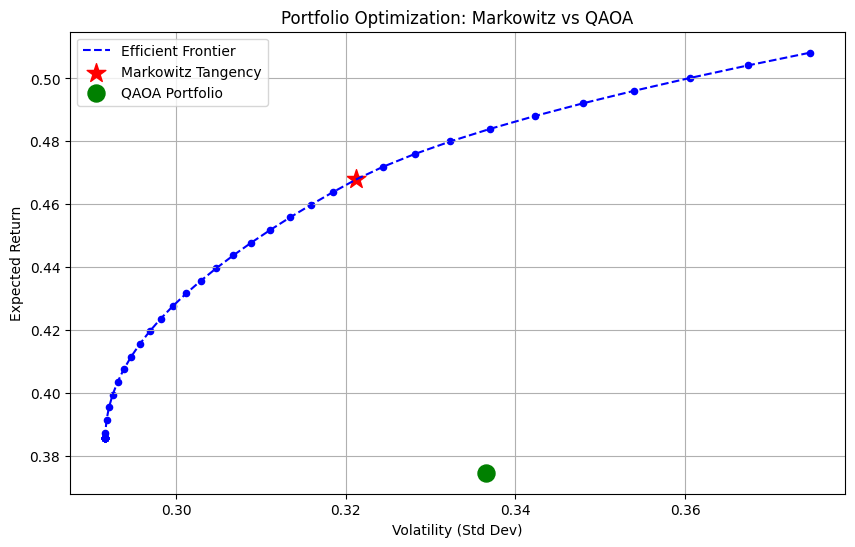

In [23]:
# -------------------------
# Visualization: Efficient Frontier + Tangency + QAOA
# -------------------------

plt.figure(figsize=(10,6))

# Plot Markowitz Efficient Frontier
plt.plot(risks, rets, 'b--', label='Efficient Frontier')
plt.scatter(risks, rets, c='blue', s=20)

# Highlight Markowitz Tangency Portfolio
plt.scatter(tangency_risk, tangency_return, c='red', marker='*', s=200, label='Markowitz Tangency')

# Highlight QAOA Portfolio
plt.scatter(risk_qaoa, ret_qaoa, c='green', marker='o', s=150, label='QAOA Portfolio')

# Labels and title
plt.xlabel('Volatility (Std Dev)')
plt.ylabel('Expected Return')
plt.title('Portfolio Optimization: Markowitz vs QAOA')
plt.legend()
plt.grid(True)
plt.show()


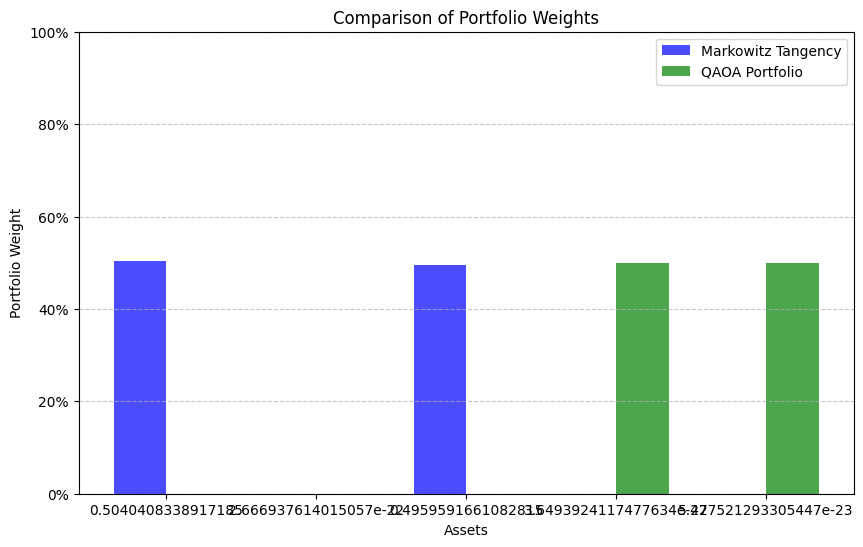

In [24]:
# -------------------------
# Bar Chart: Portfolio Weights Comparison
# -------------------------

import matplotlib.ticker as mtick

x = np.arange(len(tickers))  # positions for bars
width = 0.35                # width of bars

plt.figure(figsize=(10,6))
plt.bar(x - width/2, tangency_weights, width, label='Markowitz Tangency', color='blue', alpha=0.7)
plt.bar(x + width/2, weights_qaoa, width, label='QAOA Portfolio', color='green', alpha=0.7)

# Labels and title
plt.xlabel('Assets')
plt.ylabel('Portfolio Weight')
plt.title('Comparison of Portfolio Weights')
plt.xticks(x, tickers)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
